Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [4]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [5]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.547459
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.998490
Minibatch accuracy: 18.8%
Validation accuracy: 28.5%
Minibatch loss at step 100: 1.177609
Minibatch accuracy: 56.2%
Validation accuracy: 68.7%
Minibatch loss at step 150: 0.437632
Minibatch accuracy: 87.5%
Validation accuracy: 75.5%
Minibatch loss at step 200: 0.829733
Minibatch accuracy: 75.0%
Validation accuracy: 78.3%
Minibatch loss at step 250: 1.186727
Minibatch accuracy: 68.8%
Validation accuracy: 77.9%
Minibatch loss at step 300: 0.357657
Minibatch accuracy: 87.5%
Validation accuracy: 79.5%
Minibatch loss at step 350: 0.596358
Minibatch accuracy: 93.8%
Validation accuracy: 76.5%
Minibatch loss at step 400: 0.319524
Minibatch accuracy: 93.8%
Validation accuracy: 80.0%
Minibatch loss at step 450: 0.982719
Minibatch accuracy: 81.2%
Validation accuracy: 79.0%
Minibatch loss at step 500: 0.628628
Minibatch accuracy: 87.5%
Validation accuracy: 81.1%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [ ]:
tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)


<h2>Tensorflow specific calculations</h2>

<h3>max_pool</h3>
    - ksizes= size of the window applied for each dimension ([batch, height, width, channels] in case of NHWC data format)


<h3>conv2d function</h3>
   - strides: should be list of 4. Must have strides[0] = strides[3] = 1. For the most common case of the same horizontal and vertices strides, strides = [1, stride, stride, 1].
   - padding rules: http://stackoverflow.com/questions/34619177/what-does-tf-nn-conv2d-do-in-tensorflow
       - For the 'SAME' padding, the output height and width are computed as:

            out_height = ceil(float(in_height) / float(strides[1]))
            out_width  = ceil(float(in_width) / float(strides[2]))
            and the padding on the top and left are computed as:

            pad_along_height = ((out_height - 1) * strides[1] +filter_height - in_height)
            pad_along_width = ((out_width - 1) * strides[2] +filter_width - in_width)
            pad_top = pad_along_height / 2
            pad_left = pad_along_width / 2



        - For the 'VALID' padding, the output height and width are computed as:

        out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
        out_width  = ceil(float(in_width - filter_width + 1) / float(strides[2]))
        and the padding values are always zero. The output is then computed as

        output[b, i, j, :] =
            sum_{di, dj} input[b, strides[1] * i + di - pad_top,
                               strides[2] * j + dj - pad_left, ...] *
                         filter[di, dj, ...]
    
    

<b>Typical network design:</b>
- INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC

where the * indicates repetition, and the POOL? indicates an optional pooling layer. Moreover, N >= 0 (and usually N <= 3), M >= 0, K >= 0 (and usually K < 3). 

For example, here are some common ConvNet architectures you may see that follow this pattern:
- INPUT -> FC, implements a linear classifier. Here N = M = K = 0.
- INPUT -> CONV -> RELU -> FC
- INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC. Here we see that there is a single CONV layer between every POOL layer.
- INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC Here we see two CONV layers stacked before every POOL layer. This is generally a good idea for larger and deeper networks, because multiple stacked CONV layers can develop more complex features of the input volume before the destructive pooling operation.

In [13]:
batch_size = 64
patch_size = 5
depth = 16
num_hidden = 64
learning_rate=0.05

conv_stride=1
maxpool_ksize=2
maxpool_stride=2
maxpool_padding='VALID'



graph = tf.Graph()

with graph.as_default():
    
    # learning rate
    learning_rate=0.1
    decay_rate=0.9
    decay_steps=1000
    global_step = tf.Variable(0)  # count the number of steps taken.
    decayed_learning_rate = tf.train.exponential_decay(learning_rate=learning_rate, global_step=global_step, 
                                                   decay_steps=decay_steps, decay_rate=decay_rate, staircase=True )


    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal([patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal([image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model_2(data):
        #print("initial data shape:%s"%data.get_shape().as_list())
        conv = tf.nn.conv2d(data, layer1_weights, [1, conv_stride, conv_stride, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        #print("shape after first conv:%s"%hidden.get_shape().as_list())
        maxpool=tf.nn.max_pool(hidden,ksize=[1, maxpool_ksize, maxpool_ksize, 1], 
                               strides=[1, maxpool_stride, maxpool_stride, 1], padding=maxpool_padding)
        #print("shape after first max pool:%s"%maxpool.get_shape().as_list())
        conv = tf.nn.conv2d(maxpool, layer2_weights, [1, conv_stride, conv_stride, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        #print("shape after second conv:%s"%hidden.get_shape().as_list())
        maxpool=tf.nn.max_pool(hidden,ksize=[1, maxpool_ksize, maxpool_ksize, 1], 
                               strides=[1, maxpool_stride, maxpool_stride, 1], padding=maxpool_padding)
        #print("shape after second max pool:%s"%maxpool.get_shape().as_list())
        shape = maxpool.get_shape().as_list()
        #print("shape before flattening:%s"%shape)
        #print("shape of weights on layer 3 (outdated):%s"%layer3_weights.get_shape().as_list())
        reshape = tf.reshape(maxpool, [shape[0], shape[1] * shape[2] * shape[3]])
        #print("current shape after pooling and flattening:%s"% reshape.get_shape().as_list())
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
    logits = model_2(tf_train_dataset)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=decayed_learning_rate).minimize(loss,global_step=global_step)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model_2(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model_2(tf_test_dataset))

Initialized
Minibatch loss at step 0: 3.490494
Minibatch loss at step 100: 0.597300
Minibatch loss at step 200: 0.550167
Minibatch loss at step 300: 0.737959
Minibatch loss at step 400: 0.789963
Minibatch loss at step 500: 0.332572
Minibatch loss at step 600: 0.646374
Minibatch loss at step 700: 0.394580
Minibatch loss at step 800: 0.431072
Minibatch loss at step 900: 0.418344
Minibatch loss at step 1000: 0.347720
Minibatch loss at step 1100: 0.772137
Minibatch loss at step 1200: 0.327528
Minibatch loss at step 1300: 0.255002
Minibatch loss at step 1400: 0.521635
Minibatch loss at step 1500: 0.409179
Minibatch loss at step 1600: 0.147394
Minibatch loss at step 1700: 0.431296
Minibatch loss at step 1800: 0.385664
Minibatch loss at step 1900: 0.405382
Test accuracy: 93.9%


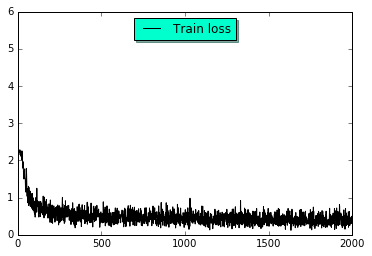

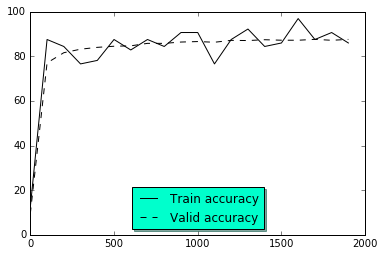

In [15]:
num_steps = 2000
lc=learningCurve()

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        current_epoch=offset/20000
        
        #collect loss for every step
        lc.append_loss(l,current_epoch,step)

        if (step % 100 == 0):
            #collect accuracies for every other step
            train_accuracy=accuracy(predictions, batch_labels)
            valid_accuracy=accuracy(valid_prediction.eval(), valid_labels)
            lc.append_accuracy(train_accuracy,valid_accuracy,current_epoch,step)
            print('Minibatch loss at step %d: %f' % (step, l))
            #print('Minibatch accuracy: %.1f%%' % train_accuracy)
            #print('Validation accuracy: %.1f%%' % valid_accuracy)
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

lc.plot_loss_curve()
lc.plot_accuracy_curve()

Different variations of of the parameters:
- learning rate = 0.05, accuracy is 90.6%
- learning rate = 0.5, accuracy is 10%
- learning rate=0.01, numsteps =10001, accuracy is 93.5%
- learning rate=0.05, batch size=64, numsteps=100001, accuracy = 95.3%

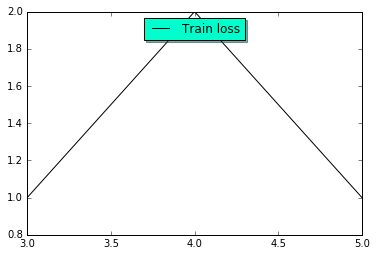

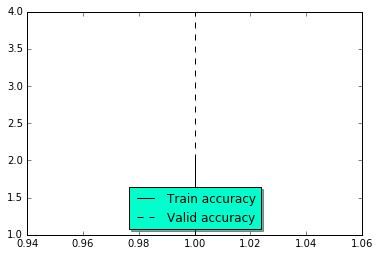

In [11]:
# A set of functions for baby-sitting of NN learning.
import matplotlib.pyplot as plt
%matplotlib inline

class learningCurve:
    
    def __init__(self):
        #accumulator for accuracy data
        self.acc_data = {}
        self.acc_data["train_accuracy"]=[]
        self.acc_data["valid_accuracy"]=[]
        self.acc_data["epoch"]=[]
        self.acc_data["iteration"]=[]

        #accumulator for loss data        
        self.loss_data={}
        self.loss_data["loss"]=[]
        self.loss_data["epoch"]=[]
        self.loss_data["iteration"]=[]
        
    def append_accuracy(self,train_accuracy,valid_accuracy,epoch,iteration):
        self.acc_data["train_accuracy"].append(train_accuracy)
        self.acc_data["valid_accuracy"].append(valid_accuracy)
        self.acc_data["epoch"].append(epoch)
        self.acc_data["iteration"].append(iteration)
        
    def append_loss(self,loss,epoch,iteration):
        self.loss_data["loss"].append(loss)
        self.loss_data["epoch"].append(epoch)
        self.loss_data["iteration"].append(iteration)        
        
        
    def plot_accuracy_curve(self,print_train=True,print_valid=True):
        # Create plots with pre-defined labels.
        if print_train:
            plt.plot(self.acc_data["iteration"], self.acc_data["train_accuracy"], 'k', label='Train accuracy')
            
        if print_valid:
            plt.plot(self.acc_data["iteration"], self.acc_data["valid_accuracy"], 'k--',  label='Valid accuracy')
            
        
        legend = plt.legend(loc='lower center', shadow=True, fontsize='large')
        legend.get_frame().set_facecolor('#00FFCC')

        plt.show()
    
    def plot_loss_curve(self):
        plt.plot(self.loss_data["iteration"], self.loss_data["loss"], 'k', label='Train loss')
        legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
        legend.get_frame().set_facecolor('#00FFCC')

        plt.show()
    
    def clear_all(self):
        self.acc_data={}
        self.loss_data={}
            


lc_test=learningCurve()
lc_test.append_loss(1.0,2.0,3.0)
lc_test.append_loss(2.0,3.0,4.0)
lc_test.append_loss(1.0,4.0,5.0)
lc_test.plot_loss_curve()

lc_test.append_accuracy(1.0,2.0,3.0,1.0)
lc_test.append_accuracy(2.0,3.0,4.0,1.0)
lc_test.append_accuracy(1.0,4.0,5.0,1.0)
lc_test.plot_accuracy_curve()
    

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---